In [1]:
import torch
import pytorch_lightning as pl
from dataset import DTU_Dataset
from network import model,model2
from audtorch.metrics import ConcordanceCC,PearsonR
from eriksdataset import EEG_Dataset
from torchmetrics.wrappers import Running
from torchmetrics.aggregation import MeanMetric
from torch.utils.data import DataLoader,TensorDataset
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,ModelSummary
import os
from diffnet import EEG_Conformer
from sklearn.model_selection import train_test_split
import numpy as np
from cdata import C_Dataset
from torch import nn
torch.set_float32_matmul_precision('medium')


In [2]:
def findfiles(search_dir, subjectstring):
    matching_files = []

    for dirpath, _, filenames in os.walk(search_dir):
        for filename in filenames:
            if subjectstring in filename:
                full_path = os.path.join(dirpath, filename)
                matching_files.append(full_path)

    return matching_files

In [3]:
class Pearsonr(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self,P,O):

        (n, t) = O.shape      # n traces of t samples
        (n_bis, m) = P.shape  # n predictions for each of m candidates

        DO = O - (torch.einsum("nt->t", O) / n) # compute O - mean(O)
        DP = P - (torch.einsum("nm->m", P) / n) # compute P - mean(P)

        cov = torch.einsum("nm,nt->mt", DP, DO)

        varP = torch.einsum("nm,nm->m", DP, DP)
        varO = torch.einsum("nt,nt->t", DO, DO)
        tmp = torch.einsum("m,t->mt", varP, varO)

        return cov / torch.sqrt(tmp)

In [4]:
class CLoss(torch.nn.Module):
    def __init__(self,scale,temp):
        super().__init__()
        self.scale = scale
        self.temp = temp
    
    def forward(self,eemb,aamb):
        

        if self.scale:
            eemb =(eemb - eemb.mean(dim=(1,2),keepdim=True))/eemb.std(dim=(1,2),keepdim=True)
            aamb =(aamb - aamb.mean(dim=(1,2),keepdim=True))/aamb.std(dim=(1,2),keepdim=True)


        norm = 1/(1e-8 + eemb.norm(dim=(1,2)))
        #norm2 = 1/(1e-8 + aamb.norm(dim=(1,2)))

        labels = torch.arange(len(eemb),device=aamb.device)

        logits = torch.einsum('btc,rtc,b->br',eemb,aamb,norm)*torch.exp(self.temp)

        return torch.nn.functional.cross_entropy(logits,labels)

In [5]:
def pearson_corr(y_true, y_pred):
    mean_true = y_true.mean(dim=1, keepdim=True)
    mean_pred = y_pred.mean(dim=1, keepdim=True)
    numerator = ((y_true - mean_true) * (y_pred - mean_pred)).sum(dim=1, keepdim=True)
    std_true = ((y_true - mean_true) ** 2).sum(dim=1, keepdim=True).sqrt()
    std_pred = ((y_pred - mean_pred) ** 2).sum(dim=1, keepdim=True).sqrt()
    denominator = std_true * std_pred
    return (numerator / (denominator + 1e-10))

def pearson_loss(y_true, y_pred):
    return -pearson_corr(y_true, y_pred)

In [6]:
class ConvBlock(nn.Module):

    def __init__(self,inp=81,dropout=0.3,kernel_size=31):

        super().__init__()

        self.conv =  nn.Sequential(
            nn.Conv1d(inp,inp*2,kernel_size=1),
            nn.GLU(dim=1),
            nn.Conv1d(inp,inp,kernel_size=kernel_size,padding="same",groups=inp),
            nn.BatchNorm1d(inp),
            nn.SiLU(),
            nn.Conv1d(inp,inp,kernel_size=1),
            nn.Dropout(dropout),
            nn.BatchNorm1d(inp),
            nn.SiLU()
        )


    def forward(self,x):
        x = self.conv(x)
        return x

In [7]:
class EnvConv(nn.Module):

    def __init__(self,inp=81,dropout=0.3,kernel_size=15,nl=4):
        super().__init__()
        self.inp = inp
        self.dropout=dropout
        self.kernel_size=kernel_size
        self.nl = nl

        self.clayers = nn.ModuleList([ConvBlock(self.inp,self.dropout,self.kernel_size) for _ in range(self.nl) ])
        self.conv1 = nn.Conv1d(81,64,kernel_size=5,stride=3)
        self.act = nn.Tanh()
        self.conv2 = nn.Conv1d(64,32,kernel_size=15,stride=2)

    def forward(self,x):

        for cl in self.clayers:
            x = x + cl(x)
        
        x = self.act(self.conv1(x))
        x = self.conv2(x)
        
        return x

In [16]:
class Encode(pl.LightningModule):
    def __init__(self):
        super().__init__()
        #self.encoder = model(nblock=2,lin_out=8,kernel_size=3,transformer_hidden=32,n_layers=2,n_heads=2,dff=16,filter_size=16,nconvs=2,times=256)
        #self.encoder = model2(transformer_hidden=32,n_heads=4,dff=128)
        self.encoder = EEG_Conformer(nblock=3,nheads=2,dropout=0.5,kernel_size=15)
        self.envc = EnvConv(dropout=0.4,nl=2,kernel_size=15)
        #self.encoder = VLAAI()
        self.temp = torch.nn.Parameter(torch.log(torch.ones(1)*0.1))
        self.loss_fn = CLoss(scale=True,temp= self.temp)
        self.running_loss1 = Running(MeanMetric(), window=32)
        self.running_loss22 = Running(MeanMetric(),window=32)
        self.tracc = Running(MeanMetric(),window=32)
        self.valacc = Running(MeanMetric(),window=32)

        self.los = PearsonR()
        self.accfn = PearsonR(reduction=None)
        self.lr = 3e-4
    

    def forward(self, eeg):
        # in lightning, forward defines the prediction/inference actions
        envelope = self.encoder(eeg)
        return envelope

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        eeg,att,mas = batch

        #eeg = eeg.unsqueeze(1)

        eeg_emb = self(eeg)
        enva = self.envc(att)
        envm = self.envc(mas)

        #comb = torch.vstack([enva,envm])




        #loss1 = self.loss_fn(eeg_emb,att)
        loss2 = -self.los(eeg_emb,enva) + self.loss_fn(eeg_emb,enva)
        #loss1 = self.loss_fn(eeg_emb,att)
        #loss = loss1+loss2


        #self.running_loss(loss1)
        self.running_loss1(loss2)
        #self.log('train_loss', self.running_loss.compute(), on_step=True, prog_bar=True)
        self.log('train_pearson_loss', self.running_loss1.compute(), on_step=True, prog_bar=True)
        #self.log('train_accuracy',)

        m1 = torch.mean(self.accfn(eeg_emb,enva),dim=1,keepdim=True)
        m2 = torch.mean(self.accfn(eeg_emb,envm),dim=1,keepdim=True)




        acc = torch.sum(m1>m2)/m1.shape[0]
        self.tracc(acc)
        self.log("train_accuracy",self.tracc.compute(),prog_bar=True,on_step=True)
        
    


        return loss2

    
    def validation_step(self, batch, batch_idx):
        # training_step defines the train loop. It is independent of forward
        eeg,att,mas = batch


        eeg_emb = self(eeg)
        enva = self.envc(att)
        envm = self.envc(mas)
        

        #comb = torch.vstack([enva,envm])




        #loss1 = self.loss_fn(eeg_emb,att)
        loss2 = -self.los(eeg_emb,enva) + self.loss_fn(eeg_emb,enva)
        #loss1 = self.loss_fn(eeg_emb,att)
        #loss = loss1+loss2

        #self.running_loss2(loss1)
        self.running_loss22(loss2)
        #self.log('valp_loss', self.running_loss2.compute(), on_step=True, prog_bar=True)
        self.log('val_loss', self.running_loss22.compute(), on_epoch=True, prog_bar=True)

        m1 = torch.mean(self.accfn(eeg_emb,enva),dim=1,keepdim=True)
        m2 = torch.mean(self.accfn(eeg_emb,envm),dim=1,keepdim=True)

        acc = torch.sum(m1>m2)/m1.shape[0]
        self.valacc(acc)
        self.log("val_accuracy",self.valacc.compute(),prog_bar=True,on_step=True)

        return loss2

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr,weight_decay=1e-6)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,800)
        return [optimizer],[scheduler]

In [8]:
tr_dataset = C_Dataset(mode="train",seconds=3,overlap=0)
val_dataset = C_Dataset(mode="val",seconds=3,overlap=0)

tr_loader = DataLoader(tr_dataset,batch_size=32,num_workers=3,persistent_workers=True,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,num_workers=3,persistent_workers=True)

In [9]:
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath='./DTUFiles/',filename='pretrained_weights',auto_insert_metric_name=False,verbose=True,enable_version_counter=False)
early_stopping = EarlyStopping('val_loss',patience=10)
ms = ModelSummary(max_depth=3)

In [10]:
enc = Encode()

trainer = pl.Trainer(max_epochs=300,accelerator='gpu',callbacks=[checkpoint_callback,ms,early_stopping],benchmark=True)
trainer.fit(enc, tr_loader,val_dataloaders=val_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\gauta\Thesis\PyTorch\DTUFiles exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                       | Type            | Params
----------------------------------------------------------------
0  | encoder                    | EEG_Conformer   | 304 K 
1  | encoder.confblock          | ModuleList      | 304 K 
2  | encoder.confblock.0        | Conformer_block | 101 K 
3  | encoder.confblock.1        | Conformer_block | 101 K 
4  | encoder.confblock.2        | Conformer_block | 101 K 
5  | encoder.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 1085: 'val_loss' reached 3.42041 (best 3.42041), saving model to 'C:\\Users\\gauta\\Thesis\\PyTorch\\DTUFiles\\pretrained_weights.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 2170: 'val_loss' reached 3.38968 (best 3.38968), saving model to 'C:\\Users\\gauta\\Thesis\\PyTorch\\DTUFiles\\pretrained_weights.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 3255: 'val_loss' reached 3.37908 (best 3.37908), saving model to 'C:\\Users\\gauta\\Thesis\\PyTorch\\DTUFiles\\pretrained_weights.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 4340: 'val_loss' reached 3.37771 (best 3.37771), saving model to 'C:\\Users\\gauta\\Thesis\\PyTorch\\DTUFiles\\pretrained_weights.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 5425: 'val_loss' was not in top 1
c:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [11]:
enc = Encode.load_from_checkpoint("./DTUFiles/pretrained_weights.ckpt")

In [9]:
dir = "Try2/"

In [10]:
train = {}
val = {}
test = {}

for i in range(1,33):
    if i ==14:
        continue
    substr = "subject_" + str(i) + "_"

    subjectlist = findfiles(dir,substr)
    spfiles,testfiles = train_test_split(subjectlist,test_size=0.12,random_state=42)
    trainfiles,valfiles = train_test_split(spfiles,test_size=0.28,random_state=42)

    train[substr] = trainfiles
    val[substr] = valfiles
    test[substr] = testfiles


In [11]:
trains = sum(train.values(),[])
vals = sum(val.values(),[])
tests = sum(test.values(),[])

In [12]:
len(set(trains + vals + tests))

2420

In [13]:
tr_dataset = EEG_Dataset(files=trains,seconds=3,overlap=0.75,fs=128)
val_dataset = EEG_Dataset(files=vals,seconds=3,overlap=0,fs=128)

tr_loader = DataLoader(tr_dataset,batch_size=32,num_workers=7,persistent_workers=True,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,num_workers=7,persistent_workers=True)

In [14]:
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath='./EriksholmFiles/',filename='pretrained_weights',auto_insert_metric_name=False,verbose=True,enable_version_counter=False)
early_stopping = EarlyStopping('val_loss',patience=10)
ms = ModelSummary(max_depth=3)

In [17]:
enc = Encode()

trainer = pl.Trainer(max_epochs=300,accelerator='gpu',callbacks=[checkpoint_callback,ms,early_stopping],benchmark=True)
trainer.fit(enc, tr_loader,val_dataloaders=val_loader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\gauta\anaconda3\envs\keras-jax\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\gauta\Thesis\PyTorch\EriksholmFiles exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                       | Type            | Params
----------------------------------------------------------------
0  | encoder                    | EEG_Conformer   | 342 K 
1  | encoder.confblock          | ModuleList      | 304 K 
2  | encoder.confblock.0        | Conformer_block | 101 K 
3  | encoder.confblock.1        | Conformer_block | 101 K 
4  | encoder.confblock.2        | Conformer_block | 101 K 
5  | en

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

torch.Size([32, 32, 366])
torch.Size([32, 32, 366])


AssertionError: 

In [16]:
245760/64

3840.0

In [16]:
mod = Encode.load_from_checkpoint("./EriksholmFiles/pretrained_weights.ckpt")

In [17]:
def predict(loader,test_model):
    test_loss = []
    test_metric = []
    test_masker = []
    acc = []

    with torch.no_grad():
        for batch_data in loader:
            inputs, outputs,masker = batch_data[0], batch_data[1],batch_data[2]
            
            # Forward pass
            predictions = test_model(inputs)
            enva = mod.envc(outputs)
            envm = mod.envc(masker)

            # Compute loss
            loss = -PearsonR()(enva, predictions).mean()

            # Compute metric
            metric = torch.mean(PearsonR(reduction=None)(enva, predictions),dim=1)
            metric2 = torch.mean(PearsonR(reduction=None)(envm, predictions),dim=1)
            accu = torch.sum(metric>metric2)

            test_loss.append(loss.item())
            test_metric.extend(metric.detach().cpu().numpy().reshape(-1))
            test_masker.extend(metric2.detach().cpu().numpy().reshape(-1))
            acc.append(accu.cpu().detach().numpy())
    
    return test_loss,np.array(test_metric),np.array(test_masker),np.array(acc)

In [18]:
accuracy = []
metric = []
masker = []
from tqdm import tqdm
mod = mod.cpu().eval()
for i in tqdm(range(1,33)):
    if i ==14:
        continue

    subject = "subject_" + str(i) + "_"
    sub_dataset = EEG_Dataset(files=test[subject],seconds=2,overlap=0)
    test_loader = DataLoader(sub_dataset,batch_size=1)

    out = predict(test_loader,mod)

    accuracy.append(np.mean(out[3]))
    metric.append(out[1])
    masker.append(out[2])



100%|██████████| 32/32 [01:49<00:00,  3.42s/it]


<BarContainer object of 31 artists>

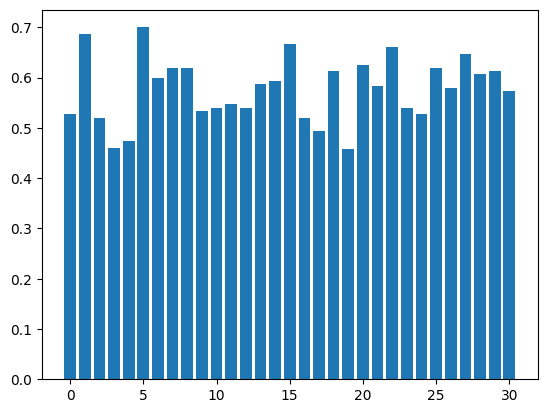

In [19]:
import matplotlib.pyplot as plt
plt.bar(np.arange(len(accuracy)),accuracy)

In [20]:
np.mean(accuracy)

0.5765591397849463

In [21]:
accuracy

[0.5266666666666666,
 0.6866666666666666,
 0.52,
 0.46,
 0.47333333333333333,
 0.7,
 0.6,
 0.62,
 0.62,
 0.5333333333333333,
 0.54,
 0.5466666666666666,
 0.54,
 0.5866666666666667,
 0.5933333333333334,
 0.6666666666666666,
 0.52,
 0.49333333333333335,
 0.6133333333333333,
 0.4583333333333333,
 0.625,
 0.5833333333333334,
 0.66,
 0.54,
 0.5266666666666666,
 0.62,
 0.58,
 0.6466666666666666,
 0.6066666666666667,
 0.6133333333333333,
 0.5733333333333334]

In [31]:
k = [z - i for z,i in zip(attmeans,masmeans)]

<BarContainer object of 31 artists>

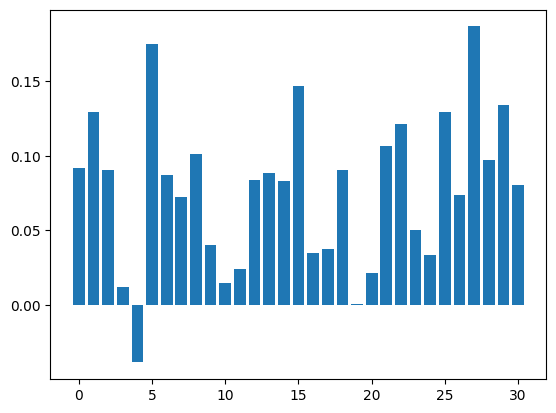

In [32]:
plt.bar(np.arange(len(k)),k)

In [22]:
met = [np.squeeze(k) for k in metric]
mas = [np.squeeze(k) for k in masker]

In [23]:
attmeans = [np.mean(r) for r in met]
masmeans = [np.mean(r) for r in mas]

<BarContainer object of 31 artists>

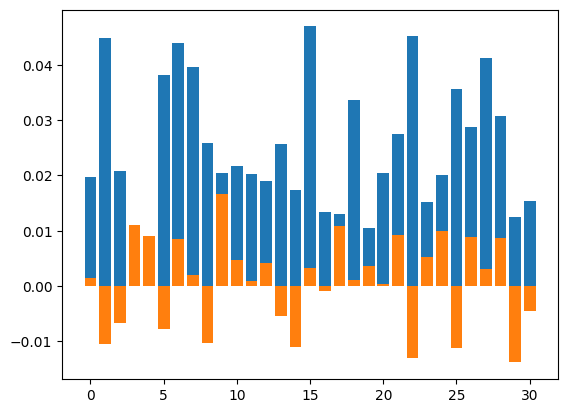

In [24]:
plt.bar(np.arange(len(attmeans)),attmeans)
plt.bar(np.arange(len(masmeans)),masmeans)

{'whiskers': [<matplotlib.lines.Line2D at 0x2509cbceb90>,
 'caps': [<matplotlib.lines.Line2D at 0x2509cbcf0d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2509cbce8f0>,
 'medians': [<matplotlib.lines.Line2D at 0x2509cbcf610>,
 'fliers': [<matplotlib.lines.Line2D at 0x2509cbcf8b0>,
 'means': []}

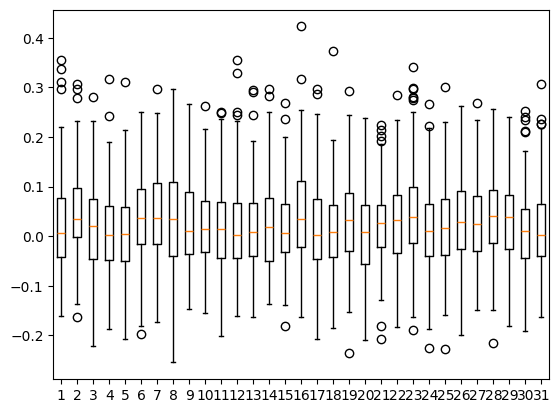

In [25]:
plt.boxplot(met)
#plt.boxplot(np.arange(len(masmeans)),mas)

{'whiskers': [<matplotlib.lines.Line2D at 0x250bb02e950>,
 'caps': [<matplotlib.lines.Line2D at 0x250bb02ee90>,
 'boxes': [<matplotlib.lines.Line2D at 0x250bb02e6b0>,
 'medians': [<matplotlib.lines.Line2D at 0x250bb02f3d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x250bb02f670>,
 'means': []}

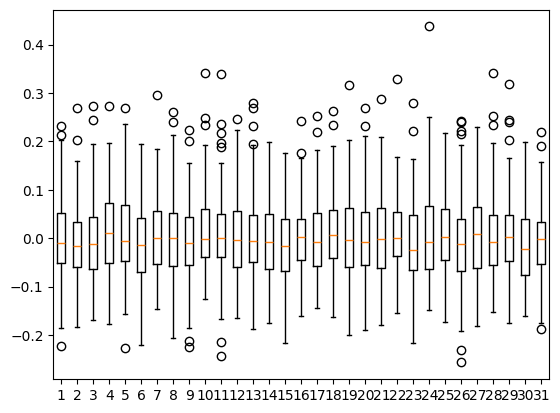

In [26]:
plt.boxplot(mas)

In [28]:
np.mean(masmeans)

0.020234512

In [29]:
np.mean(attmeans)

0.11134293